In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv('caso_full.csv')

In [3]:
data.columns

Index(['city', 'city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population', 'estimated_population_2019', 'is_last',
       'is_repeated', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'place_type', 'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

In [4]:
mapping = {}
mapping['AC'] = "Norte"
mapping['AL'] = "Nordeste"
mapping['AM'] = "Norte"
mapping['AP'] = "Norte"
mapping['BA'] = "Nordeste"
mapping['CE'] = "Nordeste"
mapping['DF'] = "Centro Oeste"
mapping['ES'] = "Sudeste"
mapping['GO'] = "Centro Oeste"
mapping['MA'] = "Nordeste"
mapping['MG'] = "Sudeste"
mapping['MS'] = "Centro Oeste"
mapping['MT'] = "Centro Oeste"
mapping['PA'] = "Norte"
mapping['PB'] = "Nordeste"
mapping['PE'] = "Nordeste"
mapping['PI'] = "Nordeste"
mapping['PR'] = "Sul"
mapping['RJ'] = "Sudeste"
mapping['RN'] = "Nordeste"
mapping['RO'] = "Centro Oeste"
mapping['RR'] = "Norte"
mapping['RS'] = "Sul"
mapping['SC'] = "Sul"
mapping['SE'] = "Nordeste"
mapping['SP'] = "Sudeste"
mapping['TO'] = "Norte"

In [5]:
# field = "last_available_confirmed_per_100k_inhabitants"
field = "total_casos"

In [6]:
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
data["total_casos"] = data["last_available_confirmed_per_100k_inhabitants"] * data["estimated_population_2019"]
columns_to_drop = ['city','place_type','last_available_confirmed',
                   'last_available_date','estimated_population',
                   'is_last','is_repeated']
data.drop(columns=columns_to_drop,inplace=True)
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['region'] = data.apply (lambda row: mapping[row["state"]], axis=1)

In [7]:
data["state"].nunique()

27

In [8]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

In [9]:
min_date = data["date"].min()
max_date = data["date"].max()
delta = max_date - min_date
dates = pd.date_range(start=min_date, end=max_date, freq='D')
def interpolate_mun(mun_data):
    #series = mun_data[["last_available_confirmed_per_100k_inhabitants","date","region"]]
    series = mun_data[[field,"date","region"]]
    region_ = series.iloc[0].region
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    series["region"] = region_
    return series

In [10]:
#agg_data = data[["last_available_confirmed_per_100k_inhabitants","city_ibge_code","region","date"]].groupby("city_ibge_code").apply(lambda x: interpolate_mun(x))
agg_data = data[[field,"city_ibge_code","region","date"]].groupby("city_ibge_code").apply(lambda x: interpolate_mun(x))

In [11]:
agg_data = agg_data.reset_index()

In [12]:
agg_data.rename(columns={"level_1": "date"},inplace=True)

In [13]:
agg_data = agg_data[[field,"region","date"]].groupby(['region',"date"]).sum()

In [14]:
grouped = agg_data.reset_index().groupby("region")

In [15]:
X = np.zeros((len(grouped),delta.days + 1))
for i,(group, data_) in enumerate(grouped):
    #series = data_[["last_available_confirmed_per_100k_inhabitants","date"]]
    series = data_[[field,"date"]]
    print(i,group)
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    X[i,:] = series.values.reshape(len(series))

0 Centro Oeste
1 Nordeste
2 Norte
3 Sudeste
4 Sul


In [16]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

In [17]:
X.shape

(5, 591)

In [18]:
l = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]

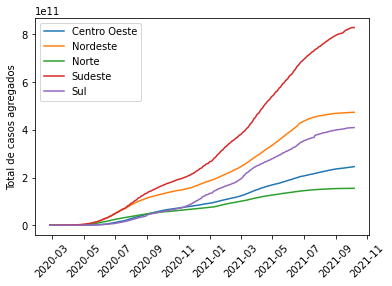

In [19]:
for i in range(5):
    plt.plot(dates,X[i,:],label=l[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [20]:
dim = int(np.floor(X.shape[1]/7))
Y = np.zeros(( 5, dim))
for t in range(dim):
    for i in range(5):
        if t < dim - 1:
            Y[i,t] = X[i,7*t+7] - X[i,7*t]
        else:
            Y[i,t] = X[i,-1]- X[i,7*t]

In [21]:
Y.shape

(5, 84)

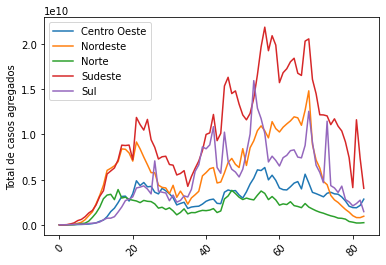

In [22]:
for i in range(5):
    plt.plot(Y[i,:],label=l[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [23]:
Y.shape

(5, 84)

In [24]:
X.shape

(5, 591)

In [25]:
#Constroi matriz de Adjacencias:
# 0 - Norte
# 1 - Centro Oeste
# 2 - Nordeste
# 3 - Sudeste
# 4 - Sul

In [26]:
A = np.zeros((5,5))

In [27]:
A[0,0] = A[0,1] = A[0,2] = A[1,0] = A[2,0] = 1
A[1,1] = A[1,2] = A[1,3] = A[1,4] = A[2,1] = A[3,1] = A[4,1] = 1
A[2,2] = A[2,3] = A[3,2] = 1
A[3,3] = A[3,4] = A[4,3] = 1
A[4,4] = 1

In [28]:
np.allclose(A,A.T)

True

In [29]:
n = 1
k = 3

In [53]:
shape = Y.shape
Y_scaled = Y/1e10
Y_scaled += 1e-3
# # shape[1] -= n
Y_hat = cp.Variable(shape)
C = [cp.Variable((shape[0],shape[0])) for i in range(k)]
constraints = []
for i in range(shape[0]):
     for t in range(shape[1]-n):
        terms = []
        for l in range(min(t,k)):
            for j in range(shape[0]):
                terms.append(C[l][i,j]*Y_scaled[j,t-l])
        constraints += [Y_hat[i,t+n] == cp.sum(terms)]

In [54]:
print(constraints[2])

var1632833[0, 3] == var1632834[0, 0] @ 0.001409375048722 + var1632834[0, 1] @ 0.0014370264026100001 + var1632834[0, 2] @ 0.001049226387947 + var1632834[0, 3] @ 0.0029189662585209996 + var1632834[0, 4] @ 0.0013075430567265 + var1632835[0, 0] @ 0.001009868972164 + var1632835[0, 1] @ 0.00102978463826 + var1632835[0, 2] @ 0.001 + var1632835[0, 3] @ 0.0012634069139505 + var1632835[0, 4] @ 0.001009604660064


In [55]:
lambda_ = 1
obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y_scaled[:,n:]) + lambda_*cp.norm1(cp.hstack(C)))
p = cp.Problem(obj,constraints)
p.solve(solver="ECOS",verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 21 07:52:25 PM: Your problem has 495 variables, 415 constraints, and 0 parameters.
(CVXPY) Jul 21 07:52:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 21 07:52:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 21 07:52:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 21 07:52:25 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 21 07:52:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

10.892821956880942

In [56]:
C[0].value

array([[1.47095965e-01, 5.97559040e-06, 1.94424377e-08, 1.76985289e-01,
        2.46447828e-02],
       [4.96057607e-09, 9.33206272e-01, 2.02246967e-08, 2.45511497e-02,
        5.14726891e-09],
       [8.37123320e-09, 1.48500517e-01, 2.80208984e-01, 2.90925668e-02,
        6.74049336e-09],
       [1.19257842e-08, 2.97696168e-01, 1.84071060e-08, 5.80436603e-01,
        4.31059542e-02],
       [7.82710166e-09, 9.34743724e-02, 6.81146513e-09, 3.31157487e-08,
        6.24617491e-01]])

In [91]:
def make_plot_Y(Y_scaled,Y_hat):
    l = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]
    for i in range(5):
        plt.plot(abs(Y_scaled[i,:] - Y_hat.value[i,:]),label=l[i])
    plt.legend()
    plt.ylabel("predict vs real")
    plt.xticks(rotation=45)
    text = f"\n Total error: {np.sum(np.abs(1 - Y_hat.value/Y_scaled)) :.2f}"
#     plt.text(0.7, 0.9,text)
    plt.title(text)
    plt.savefig(f"errors_lambda_{l}.png")
    plt.show()

In [92]:
def make_plot_C(C,l):
    a = np.array([C[i].value for i in range(k)])
    plt.hist(a.flat)
    plt.title(f"Distribution of parameters for $\lambda$={l}")
    plt.show()

In [93]:
def make_plot_C_3d(C,l):
    bins = np.linspace(-1.5, 1.5, 25)
    for i in range(k):
        a = C[i].value 
        plt.hist(a.flat,bins,alpha=0.5,label=f"lag = {i+1}")
    plt.title(f"Distribution of parameters for $\lambda$={l} over time")
    plt.legend()
    plt.savefig(f"dist_time_lambda_{l}.png")
    plt.show()

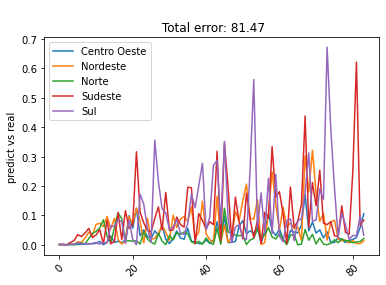

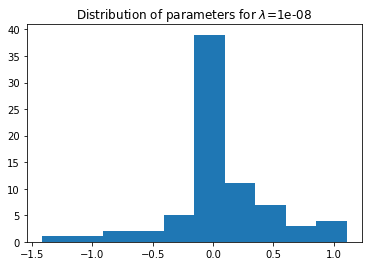

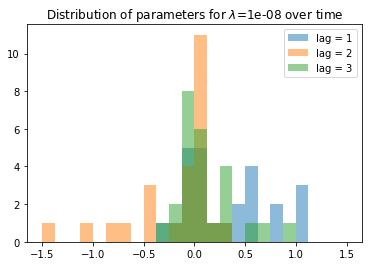

------------------------


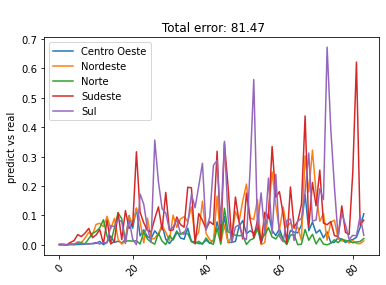

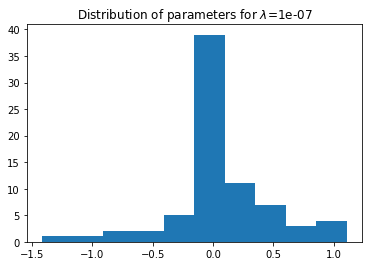

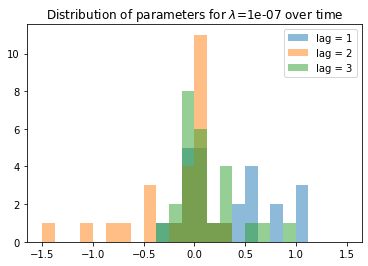

------------------------


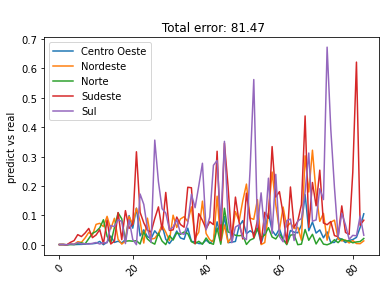

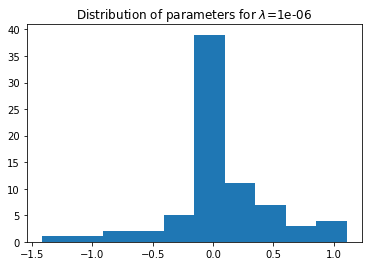

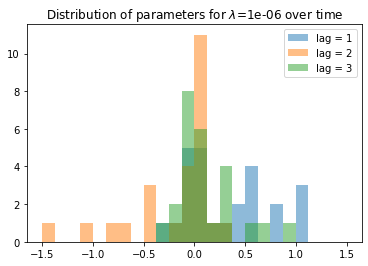

------------------------


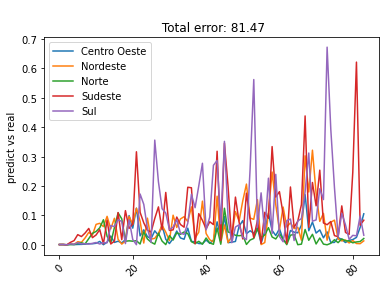

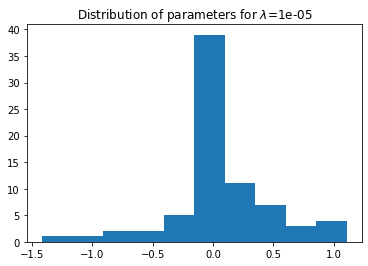

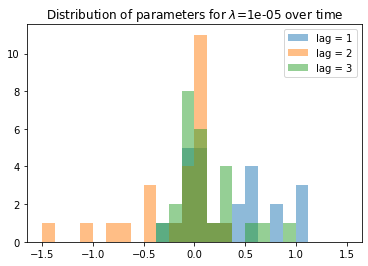

------------------------


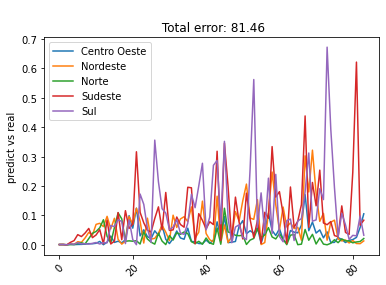

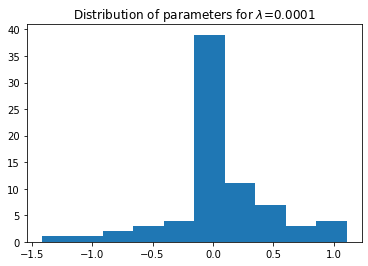

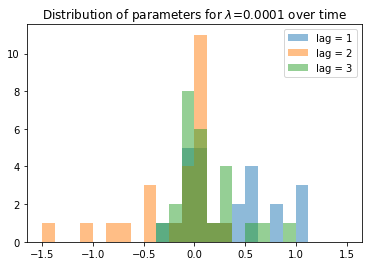

------------------------


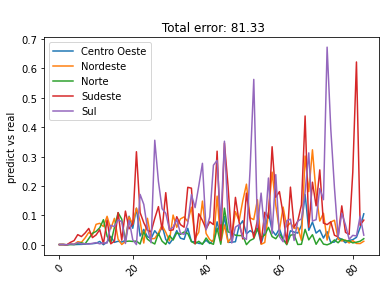

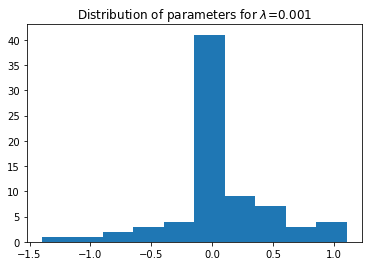

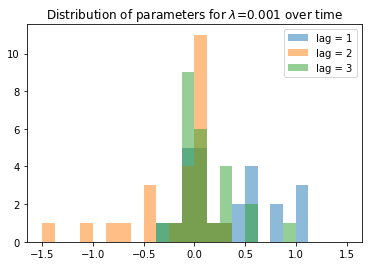

------------------------


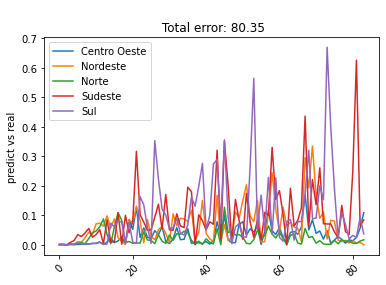

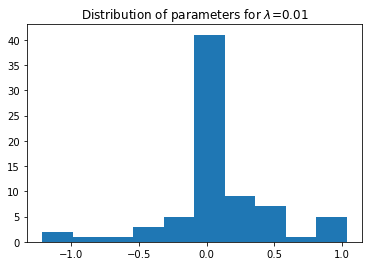

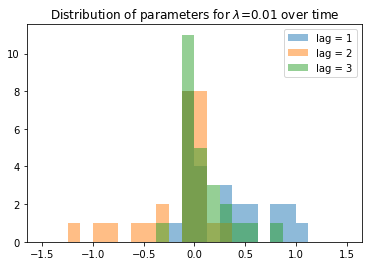

------------------------


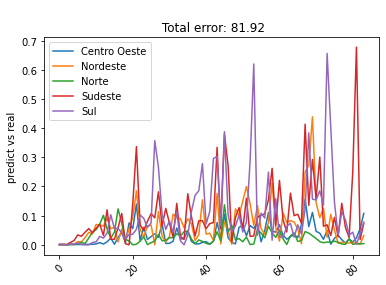

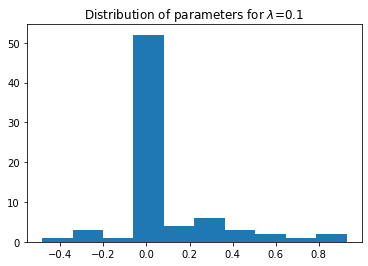

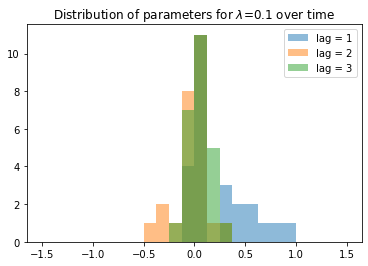

------------------------


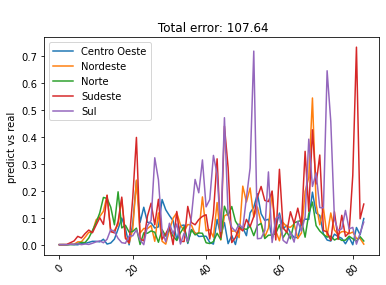

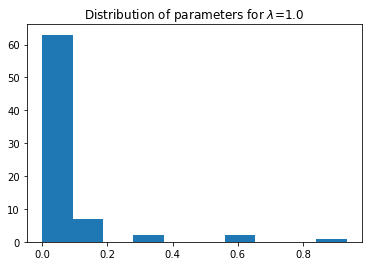

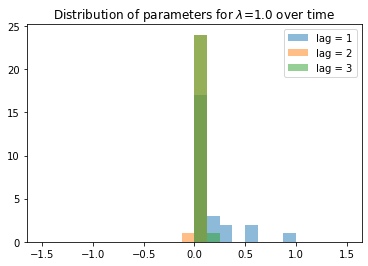

------------------------


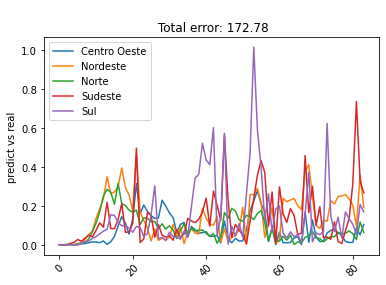

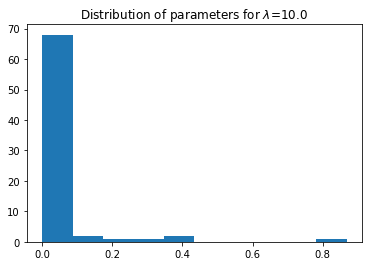

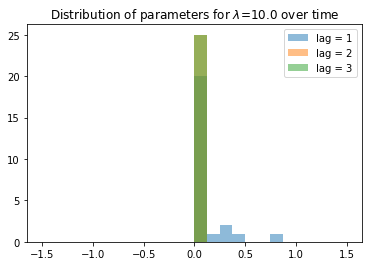

------------------------


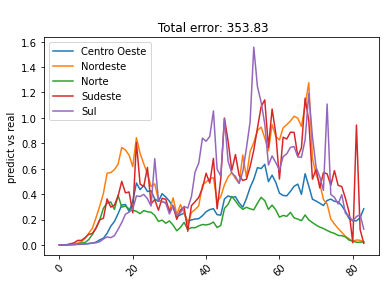

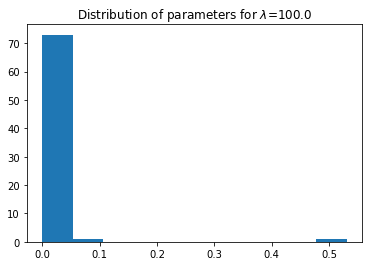

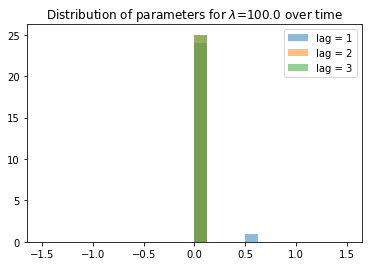

------------------------


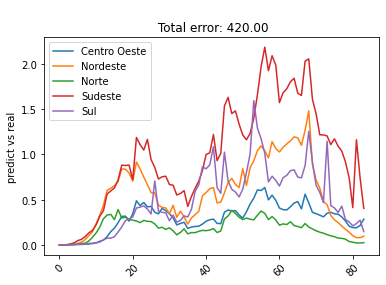

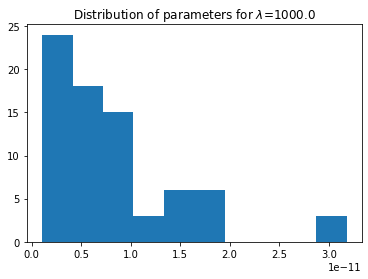

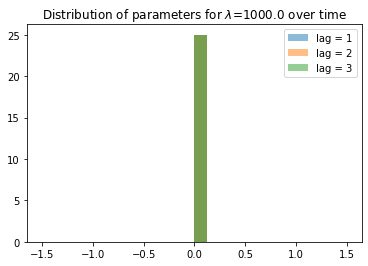

------------------------


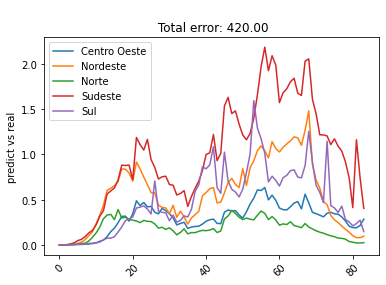

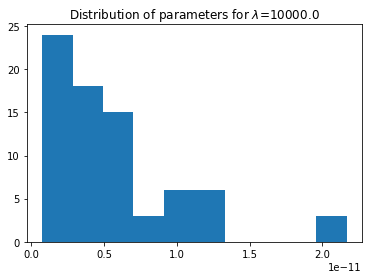

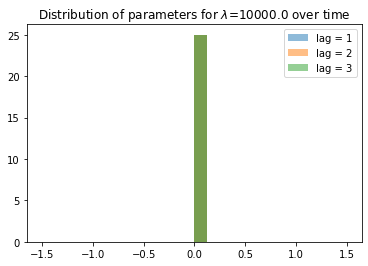

------------------------


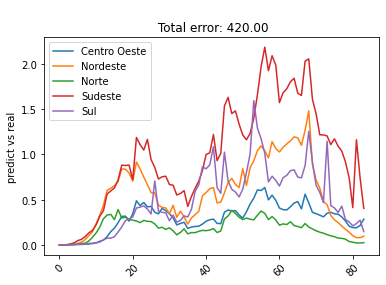

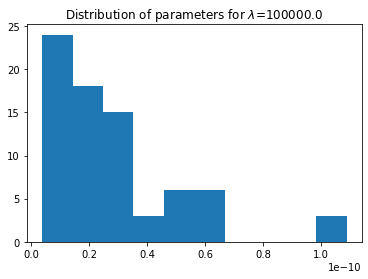

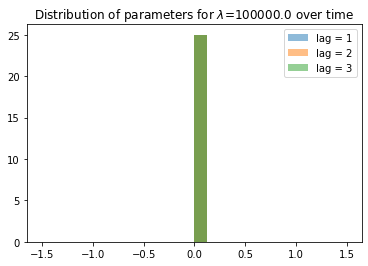

------------------------


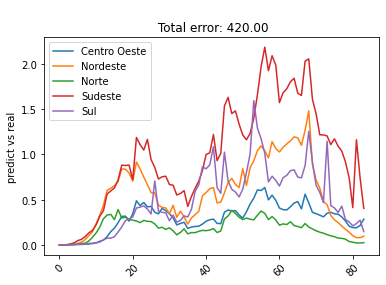

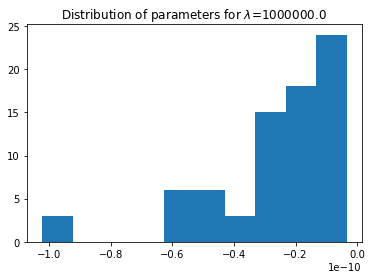

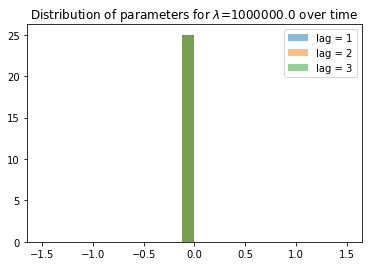

------------------------


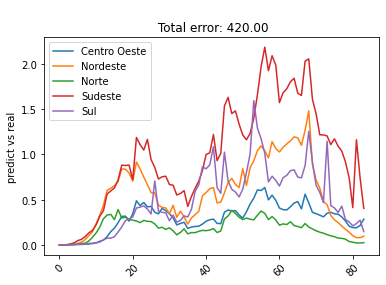

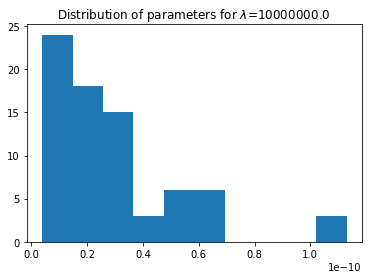

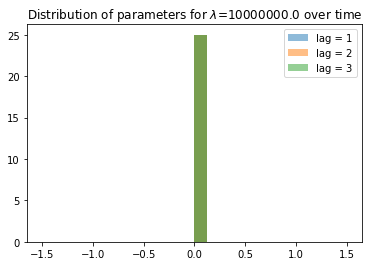

------------------------


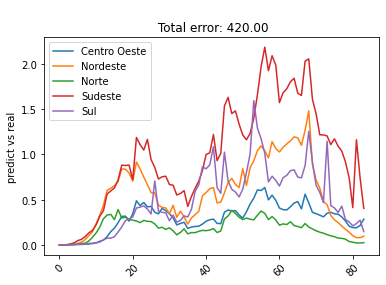

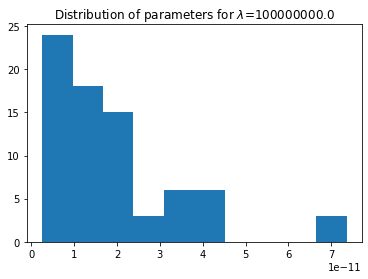

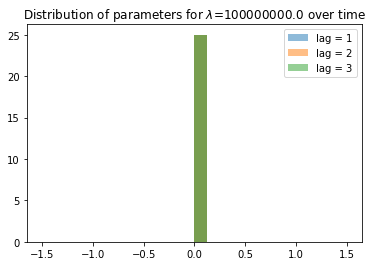

------------------------


In [94]:
for lambda_ in np.logspace(-8,8,17):
    #lambda_ = 10**i
    obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y_scaled[:,n:]) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve(solver="ECOS")
    make_plot_Y(Y_scaled,Y_hat)
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_)
    print("------------------------")

In [ ]:
min_date

In [ ]:
max_date